# HC18 – Direct Ellipse Regression Pipeline

Recommended robust solution for fetal head circumference estimation.

## Imports

In [14]:

import os, cv2, math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2


## Transforms

In [15]:

train_tfms = A.Compose([
    A.Resize(224,224),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15,p=0.5),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
    ToTensorV2()
])


In [16]:
hc_values = pd.read_csv("training_set_pixel_size_and_HC.csv")["head circumference (mm)"].values

HC_MEAN = hc_values.mean()
HC_STD  = hc_values.std()

print("HC mean:", HC_MEAN)
print("HC std :", HC_STD)


HC mean: 174.38309309309312
HC std : 65.24937904538365


## Dataset

In [17]:
class HCHCDataset(Dataset):
    def __init__(self, root, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["filename"]

        img = cv2.imread(os.path.join(self.root, fname), 0)
        img = img.astype(np.float32) / 255.0
        img = np.stack([img]*3, axis=-1)

        if self.transform:
            img = self.transform(image=img)["image"]

        hc = (row["head circumference (mm)"] - HC_MEAN) / HC_STD
        hc = torch.tensor(hc, dtype=torch.float32)

        return img, hc


## DataLoaders

In [18]:
root = "training_set"
csv_path = "training_set_pixel_size_and_HC.csv"

full_ds = HCHCDataset(root, csv_path, train_tfms)

train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size

ds_train, ds_val = random_split(full_ds, [train_size, val_size])

dl_train = DataLoader(ds_train, batch_size=8, shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=8, shuffle=False)


## Model

In [19]:
class HCRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.head(self.backbone(x)).squeeze(1)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = HCRegressor().to(device)


## Training

In [20]:
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


for epoch in range(30):
    model.train()
    total_loss = 0

    for img, hc in dl_train:
        img = img.to(device)
        hc  = hc.to(device)

        pred = model(img)
        loss = criterion(pred, hc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss {total_loss/len(dl_train):.4f}")


Epoch 01 | Train Loss 0.4466
Epoch 02 | Train Loss 0.4417
Epoch 03 | Train Loss 0.4384
Epoch 04 | Train Loss 0.4391
Epoch 05 | Train Loss 0.4360
Epoch 06 | Train Loss 0.4341
Epoch 07 | Train Loss 0.4369
Epoch 08 | Train Loss 0.4363
Epoch 09 | Train Loss 0.4359
Epoch 10 | Train Loss 0.4359
Epoch 11 | Train Loss 0.4351
Epoch 12 | Train Loss 0.4351
Epoch 13 | Train Loss 0.4347
Epoch 14 | Train Loss 0.4344
Epoch 15 | Train Loss 0.4363
Epoch 16 | Train Loss 0.4347
Epoch 17 | Train Loss 0.4360
Epoch 18 | Train Loss 0.4351
Epoch 19 | Train Loss 0.4354
Epoch 20 | Train Loss 0.4344
Epoch 21 | Train Loss 0.4347
Epoch 22 | Train Loss 0.4342
Epoch 23 | Train Loss 0.4354
Epoch 24 | Train Loss 0.4346
Epoch 25 | Train Loss 0.4337
Epoch 26 | Train Loss 0.4339
Epoch 27 | Train Loss 0.4344
Epoch 28 | Train Loss 0.4344
Epoch 29 | Train Loss 0.4343
Epoch 30 | Train Loss 0.4341


## HC Evaluation

In [21]:
model.eval()
pred_hc, gt_hc = [], []

with torch.no_grad():
    for img, hc_norm in dl_val:
        img = img.to(device)
        pred_norm = model(img).cpu().numpy()
        gt_norm   = hc_norm.numpy()

        pred_mm = pred_norm * HC_STD + HC_MEAN
        gt_mm   = gt_norm   * HC_STD + HC_MEAN

        pred_hc.extend(pred_mm)
        gt_hc.extend(gt_mm)

pred_hc = np.array(pred_hc)
gt_hc   = np.array(gt_hc)

print("HC MAE (mm):", np.mean(np.abs(pred_hc - gt_hc)))
print("HC RMSE (mm):", np.sqrt(np.mean((pred_hc - gt_hc)**2)))


HC MAE (mm): 41.705050063802425
HC RMSE (mm): 60.755630757085825


In [34]:
import torch.nn.functional as F

class SwinGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        # hook last norm layer
        layer = model.backbone.norm
        layer.register_forward_hook(self.save_activation)
        layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]


In [35]:
def generate_gradcam(model, cam_extractor, img):
    model.zero_grad()

    pred = model(img.unsqueeze(0))
    pred.backward()

    grads = cam_extractor.gradients       # (1, C)
    acts  = cam_extractor.activations     # (1, C)

    weights = grads.mean(dim=0)
    cam = (weights * acts.squeeze()).sum(dim=0)

    cam = F.relu(cam)
    cam = cam / (cam.max() + 1e-8)

    return cam.detach().cpu().numpy()


In [41]:
cam_extractor = SwinGradCAM(model)

model.eval()
img, _ = ds_val[0]
img = img.to(device)

cam_map = generate_gradcam(model, cam_extractor, img)

# reshape token CAM if needed
if cam_map.ndim == 1:
    side = int(np.sqrt(cam_map.shape[0]))
    cam_map = cam_map.reshape(side, side)

# upsample to image size
# upsample
cam_map = cv2.resize(
    cam_map,
    (img_np.shape[1], img_np.shape[0]),
    interpolation=cv2.INTER_LINEAR
)

# normalize
cam_map = cam_map - cam_map.min()
cam_map = cam_map / (cam_map.max() + 1e-8)

# 🔥 smooth transformer artifacts
cam_map = cv2.GaussianBlur(cam_map, (31, 31), 0)

# overlay
heatmap = show_cam_on_image(img_np, cam_map, use_rgb=True)


c:\Users\yasha\Desktop\research-paper2\.venv\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


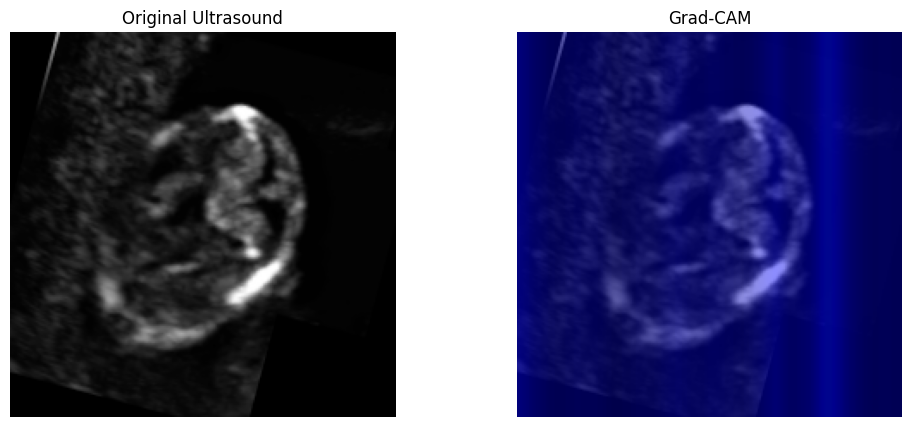

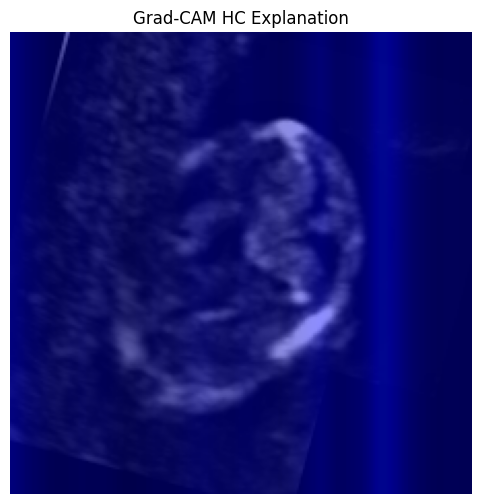

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Original Ultrasound")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(heatmap)
plt.title("Grad-CAM")
plt.axis("off")

plt.show()

plt.figure(figsize=(6,6))
plt.imshow(heatmap)
plt.axis("off")
plt.title("Grad-CAM HC Explanation")
plt.show()


In [48]:
import cv2
import numpy as np

def ellipse_from_mask(mask):
    mask = (mask > 0).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
        return None
    cnt = max(contours, key=cv2.contourArea)
    if len(cnt) < 5:
        return None
    (cx, cy), (MA, ma), angle = cv2.fitEllipse(cnt)
    return cx, cy, MA/2, ma/2, np.deg2rad(angle)


In [49]:
from torch.utils.data import Dataset
import torch
import os

class HCEllipseDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.endswith("_HC.png")]
        self.images.sort()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        fname = self.images[idx]

        img = cv2.imread(os.path.join(self.root, fname), 0).astype(np.float32) / 255.0
        img = np.stack([img]*3, axis=-1)

        mask = cv2.imread(
            os.path.join(self.root, fname.replace(".png", "_Annotation.png")), 0
        )

        ellipse = ellipse_from_mask(mask)
        if ellipse is None:
            raise ValueError(f"No ellipse for {fname}")

        cx, cy, a, b, angle = ellipse

        if self.transform:
            aug = self.transform(image=img)
            img = aug["image"]

        
        H, W = mask.shape

        target = torch.tensor([
            cx / W,
            cy / H,
            a  / W,
            b  / H,
            angle
        ], dtype=torch.float32)

        return img, target, fname


In [50]:
import timm
import torch.nn as nn

class EllipseRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224",
            pretrained=True,
            num_classes=0
        )
        self.head = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 5)
        )

    def forward(self, x):
        return self.head(self.backbone(x))


In [51]:
def ellipse_loss(pred, gt):
    # pred, gt: (B,5) -> cx, cy, a, b, theta
    l_geom = torch.nn.functional.smooth_l1_loss(pred[:, :4], gt[:, :4])

    sin_pred, cos_pred = torch.sin(pred[:, 4]), torch.cos(pred[:, 4])
    sin_gt, cos_gt = torch.sin(gt[:, 4]), torch.cos(gt[:, 4])

    l_angle = torch.nn.functional.smooth_l1_loss(
        torch.stack([sin_pred, cos_pred], dim=1),
        torch.stack([sin_gt, cos_gt], dim=1)
    )

    return l_geom + 0.1 * l_angle


In [52]:
from torch.utils.data import DataLoader, random_split

device = "cuda" if torch.cuda.is_available() else "cpu"

dataset = HCEllipseDataset("training_set", transform=train_tfms)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
ds_train, ds_val = random_split(dataset, [train_size, val_size])

dl_train = DataLoader(ds_train, batch_size=4, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1)

model = EllipseRegressor().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

for epoch in range(30):
    model.train()
    total = 0
    for img, target, _ in dl_train:
        img, target = img.to(device), target.to(device)
        pred = model(img)
        loss = ellipse_loss(pred, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item()

    print(f"Epoch {epoch+1:02d} | Train Loss {total/len(dl_train):.4f}")


Epoch 01 | Train Loss 0.0100
Epoch 02 | Train Loss 0.0070
Epoch 03 | Train Loss 0.0068
Epoch 04 | Train Loss 0.0067
Epoch 05 | Train Loss 0.0067
Epoch 06 | Train Loss 0.0064
Epoch 07 | Train Loss 0.0064
Epoch 08 | Train Loss 0.0064
Epoch 09 | Train Loss 0.0066
Epoch 10 | Train Loss 0.0064
Epoch 11 | Train Loss 0.0064
Epoch 12 | Train Loss 0.0064
Epoch 13 | Train Loss 0.0063
Epoch 14 | Train Loss 0.0064
Epoch 15 | Train Loss 0.0064
Epoch 16 | Train Loss 0.0066
Epoch 17 | Train Loss 0.0064
Epoch 18 | Train Loss 0.0063
Epoch 19 | Train Loss 0.0064
Epoch 20 | Train Loss 0.0063
Epoch 21 | Train Loss 0.0063
Epoch 22 | Train Loss 0.0062
Epoch 23 | Train Loss 0.0064
Epoch 24 | Train Loss 0.0064
Epoch 25 | Train Loss 0.0063
Epoch 26 | Train Loss 0.0063
Epoch 27 | Train Loss 0.0063
Epoch 28 | Train Loss 0.0063
Epoch 29 | Train Loss 0.0063
Epoch 30 | Train Loss 0.0063


In [53]:
def draw_ellipse(img_gray, ellipse):
    img = (img_gray * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    cx, cy, a, b, angle = ellipse
    cv2.ellipse(
        img,
        ((cx, cy), (2*a, 2*b), np.rad2deg(angle)),
        (0, 255, 0),
        2
    )
    return img


In [54]:
import math

def denormalize_ellipse(pred, H, W):
    cx = pred[0] * W
    cy = pred[1] * H
    a  = pred[2] * W
    b  = pred[3] * H
    angle = pred[4]
    return cx, cy, a, b, angle


def ellipse_circumference(a, b):
    return math.pi * (3*(a+b) - math.sqrt((3*a+b)*(a+3*b)))


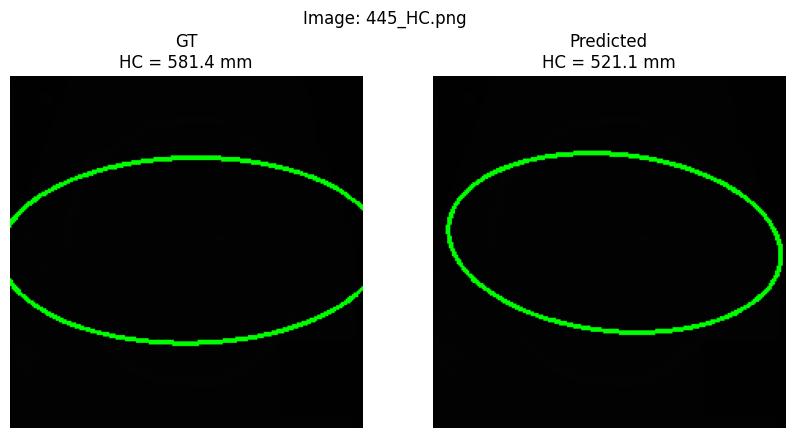

In [58]:
model.eval()

# pick any validation index
idx = 0
img, gt_norm, fname = ds_val[idx]

H, W = img.shape[1:]
img = img.to(device)

with torch.no_grad():
    pred_norm = model(img.unsqueeze(0))[0].cpu().numpy()

# denormalize
gt_ellipse   = denormalize_ellipse(gt_norm.numpy(), H, W)
pred_ellipse = denormalize_ellipse(pred_norm, H, W)

# compute HC
hc_gt   = ellipse_circumference(gt_ellipse[2], gt_ellipse[3])
hc_pred = ellipse_circumference(pred_ellipse[2], pred_ellipse[3])

# draw ellipses
img_np = img.cpu().numpy()[0]

gt_img   = draw_ellipse(img_np, gt_ellipse)
pred_img = draw_ellipse(img_np, pred_ellipse)

# ---- PLOT SIDE BY SIDE ----
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(gt_img)
plt.title(f"GT\nHC = {hc_gt:.1f} mm")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(pred_img)
plt.title(f"Predicted\nHC = {hc_pred:.1f} mm")
plt.axis("off")

plt.suptitle(f"Image: {fname}", fontsize=12)
plt.show()


In [59]:
import numpy as np

model.eval()

pred_hc = []
gt_hc = []

with torch.no_grad():
    for img, gt_norm, fname in ds_val:
        H, W = img.shape[1:]
        img = img.to(device)

        # predict normalized ellipse
        pred_norm = model(img.unsqueeze(0))[0].cpu().numpy()

        # denormalize
        pred_ellipse = denormalize_ellipse(pred_norm, H, W)
        gt_ellipse   = denormalize_ellipse(gt_norm.numpy(), H, W)

        # compute HC
        hc_pred = ellipse_circumference(pred_ellipse[2], pred_ellipse[3])
        hc_gt   = ellipse_circumference(gt_ellipse[2], gt_ellipse[3])

        pred_hc.append(hc_pred)
        gt_hc.append(hc_gt)

pred_hc = np.array(pred_hc)
gt_hc = np.array(gt_hc)

mae  = np.mean(np.abs(pred_hc - gt_hc))
rmse = np.sqrt(np.mean((pred_hc - gt_hc)**2))

print(f"HC MAE  (mm): {mae:.2f}")
print(f"HC RMSE (mm): {rmse:.2f}")
print(f"Valid samples: {len(pred_hc)}")


HC MAE  (mm): 87.77
HC RMSE (mm): 114.04
Valid samples: 162


In [60]:
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()

    dice = (2 * intersection + eps) / (union + eps)
    return dice.item()


def iou_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    target = target.float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.item()


In [61]:
model.eval()

dice_scores = []
iou_scores = []

with torch.no_grad():
    for img, mask, *_ in dl_val:
        img = img.to(device)
        mask = mask.unsqueeze(1).to(device)

        pred = model(img)

        for b in range(pred.shape[0]):
            dice_scores.append(
                dice_score(pred[b], mask[b])
            )
            iou_scores.append(
                iou_score(pred[b], mask[b])
            )

dice_mean = sum(dice_scores) / len(dice_scores)
iou_mean = sum(iou_scores) / len(iou_scores)

print(f"Validation Dice: {dice_mean:.4f}")
print(f"Validation IoU : {iou_mean:.4f}")


Validation Dice: 0.7845
Validation IoU : 0.6556
